In [1]:
## Distributed python packages
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

from math import radians, log
from sys import exit

from wmsan.subfunctions_rayleigh_waves import *
from temporal_variation import *

__author__ = "Lisa Tomasetto, Reza D.D. Esfahani"
__copyright__ = "Copyright 2024, UGA"
__credits__ = ["Lisa Tomasetto"]
__version__ = "0.1"
__maintainer__ = "Lisa Tomasetto"
__email__ = "lisa.tomasetto@univ-grenoble-alpes.fr"
__status__ = "Development"

# Temporal variations
## Secondary Microseisms Sources of Ambient Noise (Rayleigh Waves)

This Jupyter Notebook aims at modelizing ambient noise sources in the secondary microseismic band, i.e. from 2s to 12s of period.
We will compute the equivalent vertical force $\text{F}$ applied at the seafloor in $\text{N}$ every 3-hours and integrate over space to obtain a time serie.  We use oceanic hindcast WAVEWATCHIII data for this modelization.

$ F = 2\pi \sqrt{\int_{-\pi/2}^{\pi/2} \int_0^{2\pi} \int_{f_{min}}^{f_{max}} C^2(\lambda', \phi', f_s) F_{p3D}(k_2 \approx 0, f_s) R_E^2sin\phi'd\lambda'd\phi' df} $

where:
- $ f_s $ is the seismic frequency in Hz (twice the ocean wave frequency)
- $ f_{min} $ and $ f_{max} $, the lower and upper frequency bounds, in Hz.
- $ C $ the amplification coefficients for Rayleigh waves, from Longuet-Higgins (1950), no dimension.
- $ F_{p3D}(k_2 \approx 0, f_s) $ the spectral density of the pressure field at the ocean surface or directional wave spectra in $ \text{Pa}^2.\text{m}^2.\text{s}. $
- $ R_E $ the Earth's radius in m.
- $ \lambda' $ the latitude and $ \phi' $ the longitude.

In our case we will focus on the period band $ T \in [2, 12] $ s, where Rayleigh waves can be retrieved. So our maps will be integrated from $ f_{min}=0.084 \text{ Hz} $ to $ f_{max}=0.2 \text{ Hz} $. 

#### References
* Longuet-Higgins, M. S. (1950). A theory of the origin of microseisms. Philosophical Transactions of the Royal Society of London. Series A, Mathematical and Physical Sciences, 243(857), 1-35.
* Boué, P., & Tomasetto, L. (2024). Opportune detections of global P-wave propagation from microseisms interferometry. Comptes Rendus. Géoscience, 356(S4), 1-16.
* The WAVEWATCH III® Development Group (WW3DG), 2019: User manual and system documentation of WAVEWATCH III® version 6.07. Tech. Note 333, NOAA/NWS/NCEP/MMAB, College Park, MD, USA, 326 pp. + Appendices.

## Parameters
This implementation depends on a few parameters, some are described in the above formula but some are for the user to choose.
### Physical Constants
Default values are given below, please change with your own if needed.


In [2]:
F1 = 1/12  # frequency lower bound
F2 = 1/2 # frequency upper bound
parameters = [F1, F2]

## Dates
Then the dates the user wants to focus on, loops on hours, days, months and years are available setting an empty bracket symbol '[]'.

In [3]:
YEAR = 2019  # year of interest
MONTH = np.arange(1, 5)  # loop if array, compute all months of the year if empty list []
DAY = []  # loop if array, compute all days of the month if empty list []
HOUR = []  # loop if array, compute every 3 hours of the day if empty list []

date_vec = [YEAR, MONTH, DAY, HOUR]

## Spatial Extent

In [4]:
lat_min = 30 # -78 min
lat_max = 80 # 80 max
lon_min = -50 # -180 min
lon_max = 0 # 180 max

extent = [lon_min, lon_max, lat_min, lat_max]

## Paths to Files

In [5]:
# ftp path of WW3 data
ftp_path_to_files = "ftp://ftp.ifremer.fr/ifremer/ww3/HINDCAST/SISMO/GLOBAL05_%d_REF102040/"%YEAR

# local path for WW3 data
ww3_local_path = "./data/%d"%YEAR  # path where the data will be downloaded

# bathymetry default
file_bathy = "./data/LOPS_WW3-GLOB-30M_dataref_dpt.nc"  #0.5x0.5 degree grid bathymetry

paths = [file_bathy, ww3_local_path]

## Download WW3 Files
For the model files go to ftp://ftp.ifremer.fr/ifremer/ww3/HINDCAST/SISMO/, then choose the year(s) and month(s) corresponding files. We download the directional wave spectra file, extension p2l.nc (default).
It will download a .nc file containing the full output of WW3 (including significant waveheight Hs).

To download other versions add the prefix option, for example:  ```prefix = 'SWOT_WW3-GLOB-30M'```.

In [6]:
download_ww3_local(YEAR, MONTH, ftp_path_to_files, ww3_local_path)

[Errno 17] File exists: './data/2019'



2024-07-30 14:55:17 URL: ftp://ftp.ifremer.fr/ifremer/ww3/HINDCAST/SISMO/GLOBAL05_2019_REF102040/WW3-GLOB-30M_201901_p2l.nc [1369126031] -> "WW3-GLOB-30M_201901_p2l.nc" [1]


-----------------------------------------------------------------

ftp://ftp.ifremer.fr/ifremer/ww3/HINDCAST/SISMO/GLOBAL05_2019_REF102040/WW3-GLOB-30M_201901_p2l.nc downloaded

-----------------------------------------------------------------




2024-07-30 14:55:18 URL: ftp://ftp.ifremer.fr/ifremer/ww3/HINDCAST/SISMO/GLOBAL05_2019_REF102040/WW3-GLOB-30M_201902_p2l.nc [1237178665] -> "WW3-GLOB-30M_201902_p2l.nc" [1]


-----------------------------------------------------------------

ftp://ftp.ifremer.fr/ifremer/ww3/HINDCAST/SISMO/GLOBAL05_2019_REF102040/WW3-GLOB-30M_201902_p2l.nc downloaded

-----------------------------------------------------------------




2024-07-30 14:55:18 URL: ftp://ftp.ifremer.fr/ifremer/ww3/HINDCAST/SISMO/GLOBAL05_2019_REF102040/WW3-GLOB-30M_201903_p2l.nc [1376881784] -> "WW3-GLOB-30M_201903_p2l.nc" [1]


-----------------------------------------------------------------

ftp://ftp.ifremer.fr/ifremer/ww3/HINDCAST/SISMO/GLOBAL05_2019_REF102040/WW3-GLOB-30M_201903_p2l.nc downloaded

-----------------------------------------------------------------


-----------------------------------------------------------------

ftp://ftp.ifremer.fr/ifremer/ww3/HINDCAST/SISMO/GLOBAL05_2019_REF102040/WW3-GLOB-30M_201904_p2l.nc downloaded

-----------------------------------------------------------------

WW3 files downloaded in ./data/2019
current directory :  /Users/tomasetl/GITLAB/ww3-source-maps


2024-07-30 14:55:18 URL: ftp://ftp.ifremer.fr/ifremer/ww3/HINDCAST/SISMO/GLOBAL05_2019_REF102040/WW3-GLOB-30M_201904_p2l.nc [1323523619] -> "WW3-GLOB-30M_201904_p2l.nc" [1]


## Bathymetry file 
The bathymetry (or waterlevel) is necessary to compute the site effect for a given phase.

Two bathymetry grids are available for this notebook: 
- (default) "../../data/LOPS_WW3-GLOB-30M_dataref_dpt.nc": a 0.5°x0.5° bathymetry file corresponding to WW3 hindcast resolution.

- (to download) a 1 arcmin resolution ETOPOv2 bathymetry netcdf file.(```refined_bathymetry = True```) 

Both file should be located in the ```ww3-source-maps/data/``` directory.

ETOPOv2 file is also available here: https://www.ngdc.noaa.gov/thredds/catalog/global/ETOPO2022/60s/60s_bed_elev_netcdf/catalog.html?dataset=globalDatasetScan/ETOPO2022/60s/60s_bed_elev_netcdf/ETOPO_2022_v1_60s_N90W180_bed.nc
- [WARNING] use this refined bathymetry on small grids otherwise memory errors might occur (typically 30° lat x 30° lon)

If you wish to use your own bathymetry file:
- latitude in ° 1D array should be named ```zlat```.
- longitude in ° 1D array should be named ```zlon```.
- depth in meters 2D grid should be named ```dpt1```.

In [7]:
dpt1, zlon, zlat = open_bathy(file_bathy, refined_bathymetry=False, extent=extent)

### Run Temporal Variations

In [18]:
time_variation, F_variations = temporal_evolution(paths, dpt1, zlon, zlat, date_vec=date_vec, extent=extent,parameters= parameters,  c_file = "./data/C.nc", prefix = 'WW3-GLOB-30M', temporal_resolution='monthly')

File WW3  ./data/2019/WW3-GLOB-30M_201901_p2l.nc
File WW3  ./data/2019/WW3-GLOB-30M_201902_p2l.nc
File WW3  ./data/2019/WW3-GLOB-30M_201903_p2l.nc
File WW3  ./data/2019/WW3-GLOB-30M_201904_p2l.nc


## Plot Temporal Variations

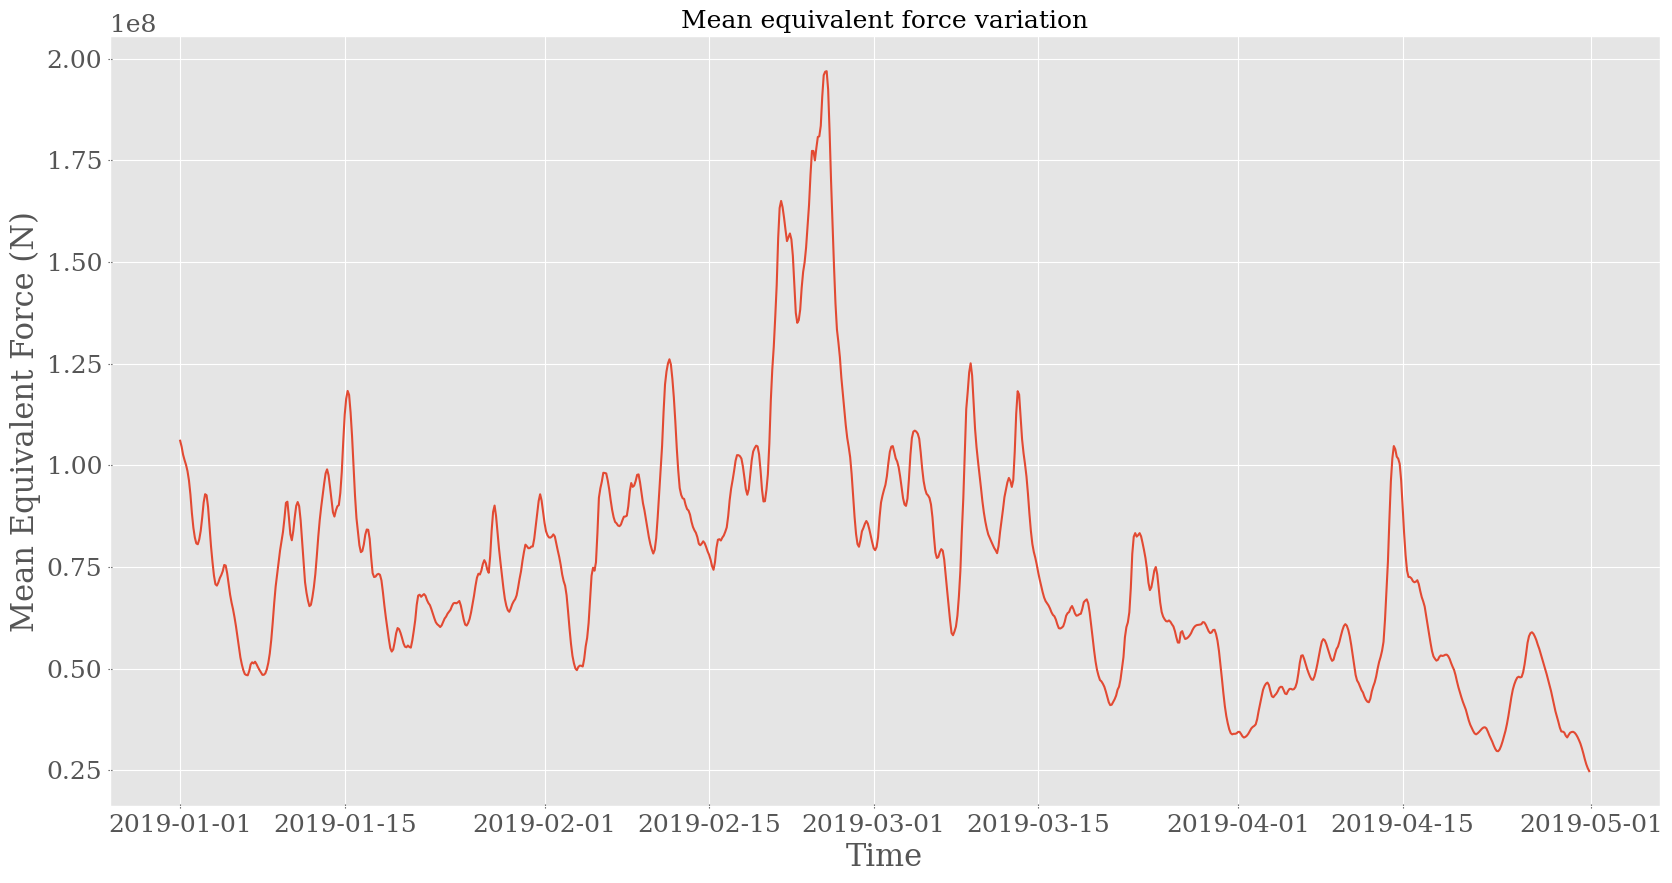

In [17]:
plt.figure(figsize=(20, 10))
plt.plot(time_variation, F_variations)
plt.xlabel('Time')
plt.ylabel('Mean Equivalent Force (N)')
plt.title('Mean equivalent force variation')
plt.show()